# US SBA Loans for Small Businesses

**About:** The project predicts the target, MIS_Status, to help financial institutions decide whether a particular loan should be approved or rejected. The dataset used comprises of the details over 899,000 applications.

**Data Source:** U.S. Small Business Administration (SBA), Kaggle

**Objectives:** To predict whether a patricular loan for a small business is expected to be paid in full or not.

**Models Used:** Logistic Regression (Baseline), Random Forest, Gradient Boosting, XGBoost, TabNet

## Library Imports

In [ ]:
#!pip install xgboost
!pip install pytorch-tabnet
#!pip install sklearn
#!pip install tensorflow
!pip install shap
!pip install --upgrade xlrd 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 163 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 1.6 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninstalling xlrd-1.2.0:
      Successfully uninstalled xlrd-1.2.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
%matplotlib inline
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score, make_scorer
import xgboost
from xgboost import XGBClassifier
import tensorflow
import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import shap
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Data Preview

We drop unique ID and borrower's organization name right away as they are useless or even noisy as features

Also, we drop ChgOffDate, ChgOffPrinGr because they can directly tell us that the loan is charged-off

'ApprovalDate', 'ApprovalFY', 'DisbursementDate' are also dropped to make the model time-independent

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/SBAnational.csv').drop(columns=['LoanNr_ChkDgt', 'Name', 'ChgOffDate', 'ChgOffPrinGr',
                                                            'ApprovalDate', 'ApprovalFY', 'DisbursementDate'])
len_data = len(data)
data

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.


,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,MIS_Status,GrAppv,SBA_Appv
0,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,2.0,0,0,1,0,N,Y,"$60,000.00",$0.00,P I F,"$60,000.00","$48,000.00"
1,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,2.0,0,0,1,0,N,Y,"$40,000.00",$0.00,P I F,"$40,000.00","$32,000.00"
2,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,1.0,0,0,1,0,N,N,"$287,000.00",$0.00,P I F,"$287,000.00","$215,250.00"
3,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,0,0,1,0,N,Y,"$35,000.00",$0.00,P I F,"$35,000.00","$28,000.00"
4,ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,240,14,1.0,7,7,1,0,N,N,"$229,000.00",$0.00,P I F,"$229,000.00","$229,000.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,60,6,1.0,0,0,1,0,0,N,"$70,000.00",$0.00,P I F,"$70,000.00","$56,000.00"
899160,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,60,6,1.0,0,0,1,0,Y,N,"$85,000.00",$0.00,P I F,"$85,000.00","$42,500.00"
899161,SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,108,26,1.0,0,0,1,0,N,N,"$300,000.00",$0.00,P I F,"$300,000.00","$225,000.00"
899162,HONOLULU,HI,96830,BANK OF HAWAII,HI,0,60,6,1.0,0,0,1,0,N,Y,"$75,000.00",$0.00,CHGOFF,"$75,000.00","$60,000.00"


## Data Preprocessing

We convert the strings styled as '$XXXX.XX' to float values

In [ ]:
money_cols = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']

for col in money_cols:
    data[col] = [float(val[1:].replace(',', '')) for val in data[col].values]

**Imputation:** Let's check our data for missing values and fill NAs with mode

In [ ]:
for col in data.drop(columns=['MIS_Status']).columns:
    if data[col].isna().any():
        data[col] = data[col].fillna(data[col].mode().iloc[0])
    if data[col].isnull().any():
        data[col] = data[col].fillna(data[col].mode().iloc[0])

The features, RevLineCr and LowDoc, should have binary values Y and N but they're of the Object dtype, so we drop the rows with noisy data

In [ ]:
print(data.RevLineCr.value_counts())

N    424816
0    257602
Y    201397
T     15284
1        23
R        14
`        11
2         6
C         2
3         1
,         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: RevLineCr, dtype: int64


In [ ]:
print(data.LowDoc.value_counts())

N    785404
Y    110335
0      1491
C       758
S       603
A       497
R        75
1         1
Name: LowDoc, dtype: int64


In [ ]:
data = data[(data['RevLineCr'] == 'N')|(data['RevLineCr'] == 'Y')]
data['RevLineCredit'] = [1 if app == 'Y' else 0 for app in data.LowDoc.values]
data = data.drop(columns=['RevLineCr'])
print(data.RevLineCredit.value_counts())

0    566606
1     59607
Name: RevLineCredit, dtype: int64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
data = data[(data['LowDoc'] == 'N')|(data['LowDoc'] == 'Y')]
data['LowDocLoan'] = [1 if app == 'Y' else 0 for app in data.LowDoc.values]
data = data.drop(columns=['LowDoc'])
print(data.LowDocLoan.value_counts())

0    563776
1     59607
Name: LowDocLoan, dtype: int64


We have many columns with Object dtype; let's apply one hot encoding (if the number of unique values is relatively small)
or hashing if there are many uniques

In [ ]:
cols_to_drop = []

for col in data.drop(columns=['MIS_Status']).columns:
  if data[col].dtype == 'object':
    print(f'Column {col} has {data[col].nunique()} values among {len_data}')

    if data[col].nunique() < 25:
      print(f'One-hot encoding of {col}')
      one_hot_cols = pd.get_dummies(data[col])
      for ohc in one_hot_cols.columns:
        data[col + '_' + ohc] = one_hot_cols[ohc]
    else:
      print(f'Hashing of {col}')
      data[col + '_hash'] = data[col].apply(lambda row: int(hashlib.sha1((col + "_" + str(row)).encode('utf-8')).hexdigest(), 16) % len_data)

    cols_to_drop.append(col)
data = data.drop(columns=cols_to_drop)

Column City has 28739 values among 899164
Hashing of City
Column State has 51 values among 899164
Hashing of State
Column Bank has 5482 values among 899164
Hashing of Bank
Column BankState has 55 values among 899164
Hashing of BankState


MIS_Status (our target) variable, is 'PIF' if the loan is returned and 'CHGOFF' if the borrower had a debt. So, we can convert the target variable from string to binary

In [ ]:
data['Defaulted'] = [1 if app == 'CHGOFF' else 0 for app in data.MIS_Status.values]
data = data.drop(columns=['MIS_Status'])

Finally, our data looks like this

In [ ]:
data

,Zip,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,RevLineCredit,LowDocLoan,City_hash,State_hash,Bank_hash,BankState_hash,Defaulted
0,47711,451120,84,4,2.0,0,0,1,0,60000.0,0.0,60000.0,48000.0,1,1,516891,257285,472792,679759,0
1,46526,722410,60,2,2.0,0,0,1,0,40000.0,0.0,40000.0,32000.0,1,1,489420,257285,98094,678090,0
2,47401,621210,180,7,1.0,0,0,1,0,287000.0,0.0,287000.0,215250.0,0,0,139156,257285,871129,678090,0
3,74012,0,60,2,1.0,0,0,1,0,35000.0,0.0,35000.0,28000.0,1,1,428377,244284,265846,64579,0
4,32801,0,240,14,1.0,7,7,1,0,229000.0,0.0,229000.0,229000.0,0,0,26459,312726,848798,220708,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899158,75062,0,84,5,2.0,0,0,1,0,79000.0,0.0,79000.0,63200.0,1,1,469999,632103,198851,649622,0
899160,43221,451130,60,6,1.0,0,0,1,0,85000.0,0.0,85000.0,42500.0,0,0,224796,110708,408224,852912,0
899161,93455,332321,108,26,1.0,0,0,1,0,300000.0,0.0,300000.0,225000.0,0,0,126786,196413,412134,534307,0
899162,96830,0,60,6,1.0,0,0,1,0,75000.0,0.0,75000.0,60000.0,1,1,680371,537481,847670,547142,1


The dataset is quite imbalanced: the amount of non-defaulted loans is 5x of that of defaulted ones

In [ ]:
print(data.Defaulted.value_counts())

0    511303
1    112080
Name: Defaulted, dtype: int64


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


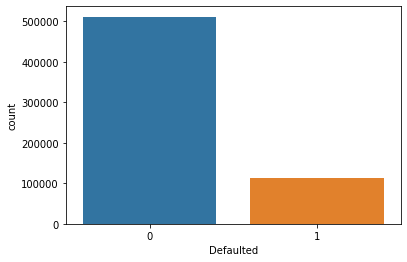

In [ ]:
sns.countplot(data.Defaulted)

**Splitting our dataset into X and y to separate the predictors from the target** 

In [ ]:
X = data.drop(columns=['Defaulted'])
Y = data.Defaulted

**Create training and testing sets**<br>
In cases with balanced data, we can generate a train/test set simply by randomly assigning a part of the data to a test set. However, in imbalanced data, there is a big risk of ending up with almost no cases of the minority class in the test set. <br>
Since our dataset is imbalanced, we use stratified sampling, which will force the same class balance on the train and test dataset as the original data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=data.Defaulted)

**Let's train our baseline model, i.e. a logistic regression model**

 Logistic regression was chosen as the baseline, as it is one of the most simple classification models.

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train.tolist())
print(f"Classification report on the test set (when model trained on imbalanced data) is:")
print(classification_report(y_test, clf.predict(X_test)))


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Classification report on the test set (when model trained on imbalanced data) is:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90    102261
           1       0.33      0.00      0.01     22416

    accuracy                           0.82    124677
   macro avg       0.57      0.50      0.45    124677
weighted avg       0.73      0.82      0.74    124677



**Oversampling**<br>
An class imbalance creates a bias where the machine learning model tends to predict the majority class. <br>
We can use oversampling to resample the minority class proportion following the majority class proportion.

In [ ]:
smote = SMOTE()
X_oversample, y_oversample = smote.fit_resample(X_train, y_train)
clf_over = LogisticRegression()
clf_over.fit(X_oversample, y_oversample)
print(f"Classification report on the test set (when model trained on oversampled data) is:")
print(classification_report(y_test, clf_over.predict(X_test)))


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Classification report on the test set (when model trained on oversampled data) is:
              precision    recall  f1-score   support

           0       0.94      0.62      0.75    102261
           1       0.32      0.80      0.46     22416

    accuracy                           0.66    124677
   macro avg       0.63      0.71      0.60    124677
weighted avg       0.82      0.66      0.70    124677



Class distribution of oversampled data

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


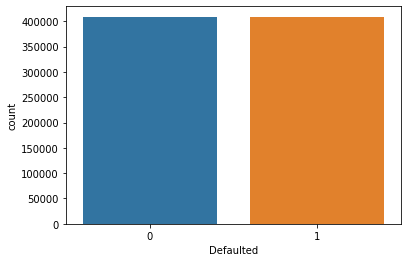

In [ ]:
sns.countplot(y_oversample)


**Undersampling**<br>
Undersampling is another technique which would decrease the proportion of your majority class until the number is similar to the minority class. Since the size of our minority class is 112,080, we would still have a good amount of data to work with.

In [ ]:
under = RandomUnderSampler(sampling_strategy=0.5)
X_undersample, y_undersample = under.fit_resample(X_train, y_train)
clf_under = LogisticRegression()
clf_under.fit(X_undersample, y_undersample)
print(f"Classification report on the test set (when model trained on undersampled data) is:")
print(classification_report(y_test, clf_under.predict(X_test)))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Classification report on the test set (when model trained on undersampled data) is:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88    102261
           1       0.28      0.09      0.13     22416

    accuracy                           0.79    124677
   macro avg       0.55      0.52      0.51    124677
weighted avg       0.73      0.79      0.75    124677



Class distribution of undersampled data

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


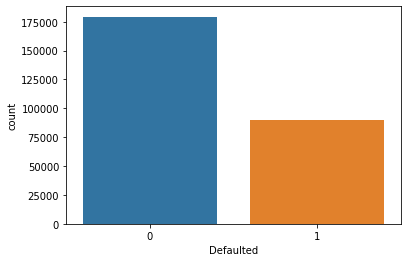

In [ ]:
sns.countplot(y_undersample)

**Let's fit and cross-validate a balanced random forest**


Random forest was implemented as it is commonly used for classification problems. Random forests are well-suited to this task because they can handle large datasets with a multitude of features, and they are able to make accurate predictions even when the data is highly unbalanced or when there are missing values.

Random Forest classifier on imbalanced data

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)
rfc.fit(X_train, y_train.tolist())
f1_scorer = make_scorer(f1_score)
auc_scorer = make_scorer(roc_auc_score)
cross_validate(rfc, X, Y, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  8.8min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.4min finished


{'fit_time': array([261.91686106, 271.89832258, 240.7934556 , 224.6168561 ,
        148.72328448]),
 'score_time': array([15.7850306 , 14.12567091, 11.66959238, 11.98889637,  8.99327564]),
 'test_f1_weighted': array([0.94557425, 0.94530073, 0.94515939, 0.94593953, 0.94559054]),
 'test_roc_auc': array([0.97513395, 0.97479365, 0.97492542, 0.97682919, 0.97526951])}

Random Forest classifier on undersampled data

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)
cross_validate(rfc, X_undersample, y_undersample, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  8.8min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.4min finished


{'fit_time': array([261.91686106, 271.89832258, 240.7934556 , 224.6168561 ,
        148.72328448]),
 'score_time': array([15.7850306 , 14.12567091, 11.66959238, 11.98889637,  8.99327564]),
 'test_f1_weighted': array([0.94557425, 0.94530073, 0.94515939, 0.94593953, 0.94559054]),
 'test_roc_auc': array([0.97513395, 0.97479365, 0.97492542, 0.97682919, 0.97526951])}

Random Forest classifier on oversampled data

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)
cross_validate(rfc, X_oversample, y_oversample, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 12.2min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.5min finished


{'fit_time': array([341.87708259, 348.66701508, 356.69496512, 373.74128938,
        247.3911202 ]),
 'score_time': array([14.95868373, 14.9810667 , 15.35966682, 15.62646127, 11.29142785]),
 'test_f1_weighted': array([0.96106756, 0.96074973, 0.96054804, 0.96037674, 0.96084727]),
 'test_roc_auc': array([0.99249629, 0.99196222, 0.99199429, 0.99225002, 0.99240925])}

## Feature Importance

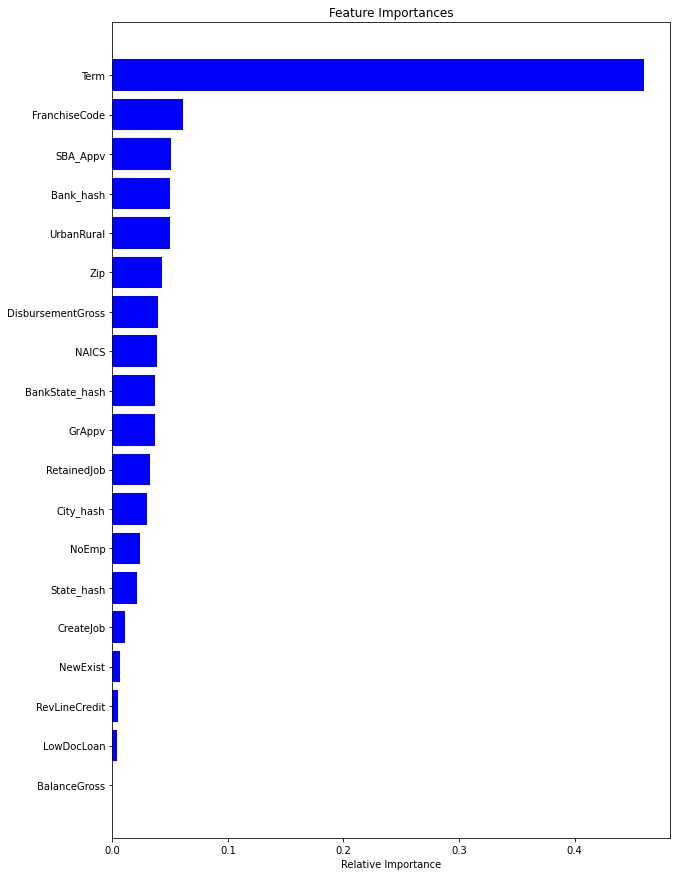

In [ ]:
rfc.fit(X_train, y_train.tolist())
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

This plot is an indicator of the impact each feature has on the model.

There are 2 classes for this prediction, 0 and 1. 0 means that a business does not default on their loan, 1 means that they do. <br>
Shapley values are a popular way of measuring the contribution of each feature towards the target.

In [ ]:
explainer = shap.TreeExplainer(rfc)
print(f"Expected value for class 0 (make payment): {explainer.expected_value[0]}, class 1 (default on payment): {explainer.expected_value[1]}")

**Let's see the dominant factors overall.**

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_train.iloc[:1000])
shap.force_plot(explainer.expected_value[0], np.array(shap_values)[0], X_train[:1000])

**Summary plot**

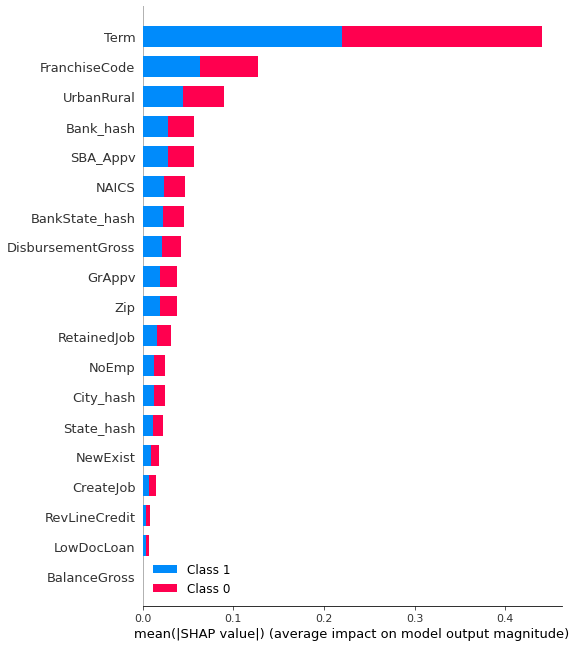

In [ ]:
shap.summary_plot(shap_values, X_train.iloc[0:1000], plot_type="bar")


**Shap value for each feature:**

In [ ]:

train_X_labels = data.columns[:-1]

vals = np.mean(np.abs(np.array(shap_values)[0]), axis = 0)
vals
for label, val in zip(train_X_labels, vals):
  print(f"SHAP value for {label} is {val}")

SHAP value for Zip is 0.01890994401377471
SHAP value for NAICS is 0.02322698367510382
SHAP value for Term is 0.22006351025188287
SHAP value for NoEmp is 0.012580793921917627
SHAP value for NewExist is 0.009141849696416862
SHAP value for CreateJob is 0.007316677531283974
SHAP value for RetainedJob is 0.015444985166382721
SHAP value for FranchiseCode is 0.06351317026640584
SHAP value for UrbanRural is 0.04496850592494259
SHAP value for DisbursementGross is 0.021028191366706053
SHAP value for BalanceGross is 3.55837672483233e-07
SHAP value for GrAppv is 0.01924982497520747
SHAP value for SBA_Appv is 0.028154432423911042
SHAP value for RevLineCredit is 0.004204688033026434
SHAP value for LowDocLoan is 0.003550924285495396
SHAP value for City_hash is 0.012459751500723492
SHAP value for State_hash is 0.011516460691787831
SHAP value for Bank_hash is 0.02832042398482417
SHAP value for BankState_hash is 0.022880259489895523


We can see that overall, 'Term' is the most important feature, followed by whether the business is a franchise.

## Correlation between features

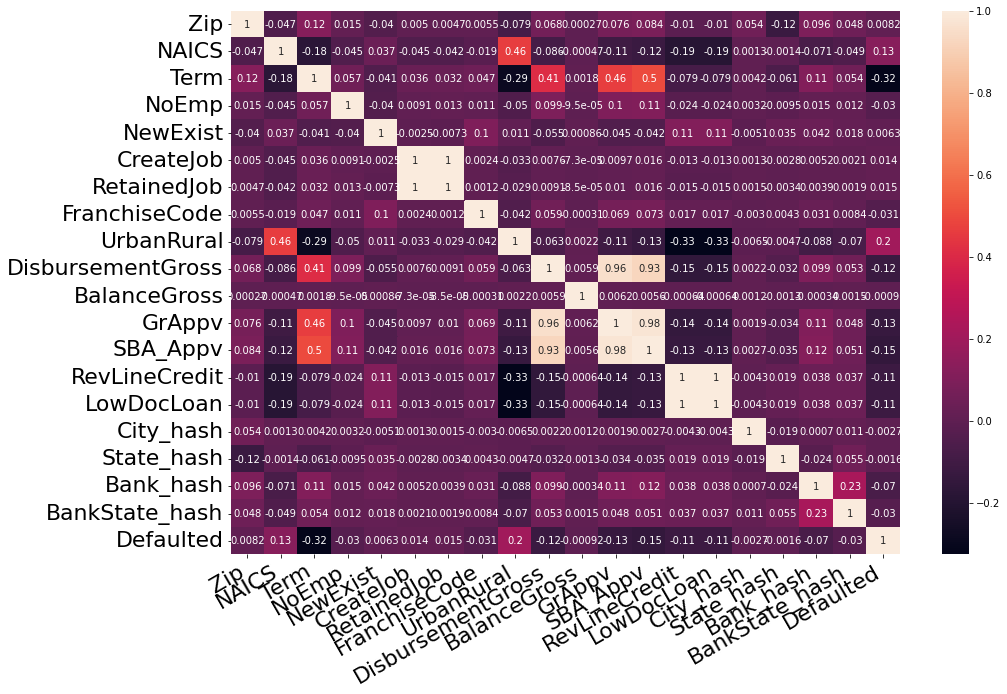

In [ ]:
cor_fig, cor_ax = plt.subplots(figsize=(15, 10))
corr_matrix = data.corr()
cor_ax = sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=30, horizontalalignment='right', fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('correlation.png')
plt.show()

##Models and their performance

Calculating the F1 and AUC scores for **Logistic Regression model**

For imbalanced data:

In [ ]:
cross_validate(rfc, X, Y, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

For undersampled data:

In [ ]:
cross_validate(rfc, X_undersample, y_undersample, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

For oversampled data:

In [ ]:
cross_validate(rfc, X_oversample, y_oversample, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

**Gaussian Naive Bayes Model:**

Gaussian Naive Bayes classifier on imbalanced data

In [ ]:
clf2 = GaussianNB()
cross_validate(clf2, X, Y, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


{'fit_time': array([0.53412247, 0.53121591, 0.46314287, 0.51551199, 0.36045766]),
 'score_time': array([0.33454227, 0.32717633, 0.31969237, 0.30961895, 0.2031877 ]),
 'test_f1_weighted': array([0.41109332, 0.47480083, 0.41214943, 0.40964933, 0.4104304 ]),
 'test_roc_auc': array([0.77061849, 0.77211834, 0.76888029, 0.77203183, 0.76826668])}

Gaussian Naive Bayes classifier on undersampled data

In [ ]:
clf2 = GaussianNB()
cross_validate(clf2, X_undersample, y_undersample, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.8s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


{'fit_time': array([0.7173121 , 0.6656127 , 0.51629972, 0.54961777, 0.3743608 ]),
 'score_time': array([0.36901689, 0.36511827, 0.37607598, 0.35701895, 0.24205852]),
 'test_f1_weighted': array([0.57471172, 0.54773276, 0.54931829, 0.54977988, 0.55035606]),
 'test_roc_auc': array([0.78351673, 0.78157402, 0.78236823, 0.78283594, 0.78395204])}

Gaussian Naive Bayes classifier on oversampled data

In [ ]:
clf2 = GaussianNB()
cross_validate(clf2, X_oversample, y_oversample, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.8s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


{'fit_time': array([0.7173121 , 0.6656127 , 0.51629972, 0.54961777, 0.3743608 ]),
 'score_time': array([0.36901689, 0.36511827, 0.37607598, 0.35701895, 0.24205852]),
 'test_f1_weighted': array([0.57471172, 0.54773276, 0.54931829, 0.54977988, 0.55035606]),
 'test_roc_auc': array([0.78351673, 0.78157402, 0.78236823, 0.78283594, 0.78395204])}

**Gradient Boosting Classifier:**

Gradient Boosting classifier on imbalanced data

In [ ]:
clf3 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
cross_validate(clf3, X, Y, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.8min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.9min finished


{'fit_time': array([114.74152923, 114.63286543, 112.4068284 , 110.60821724,
         68.05235219]),
 'score_time': array([0.55075502, 0.7797544 , 0.50390482, 0.66584134, 0.42167497]),
 'test_f1_weighted': array([0.91995641, 0.91958524, 0.9194674 , 0.92019383, 0.92112443]),
 'test_roc_auc': array([0.94665705, 0.9453164 , 0.94591885, 0.94718129, 0.94577466])}

Gradient Boosting classifier on undersampled data

In [ ]:
clf3 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
cross_validate(clf3, X_undersample, y_undersample, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.9min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min finished


{'fit_time': array([192.75017929, 190.62263179, 159.53597856, 156.8243258 ,
         96.09289312]),
 'score_time': array([1.20219922, 0.74395156, 0.81935382, 0.8754034 , 0.53573704]),
 'test_f1_weighted': array([0.91681866, 0.91739601, 0.91602373, 0.91727939, 0.9188548 ]),
 'test_roc_auc': array([0.97292617, 0.9722253 , 0.97241689, 0.97239541, 0.97353565])}

Gradient Boosting classifier on oversampled data

In [ ]:
clf3 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
cross_validate(clf3, X_oversample, y_oversample, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.9min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min finished


{'fit_time': array([192.75017929, 190.62263179, 159.53597856, 156.8243258 ,
         96.09289312]),
 'score_time': array([1.20219922, 0.74395156, 0.81935382, 0.8754034 , 0.53573704]),
 'test_f1_weighted': array([0.91681866, 0.91739601, 0.91602373, 0.91727939, 0.9188548 ]),
 'test_roc_auc': array([0.97292617, 0.9722253 , 0.97241689, 0.97239541, 0.97353565])}

**XGBoost Classifier:**

XGBoost classifier on imbalanced data

In [ ]:
clf4 = XGBClassifier()
cross_validate(clf4, X, Y, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  3.7min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


{'fit_time': array([112.2498138 , 112.24077153, 104.22710967, 104.35630012,
         53.45544767]),
 'score_time': array([1.32934904, 1.34885693, 1.25851941, 1.20955992, 0.93273973]),
 'test_f1_weighted': array([0.92781597, 0.92809513, 0.92869741, 0.9300388 , 0.92810111]),
 'test_roc_auc': array([0.96223931, 0.9614974 , 0.96272873, 0.96346081, 0.96279786])}

XGBoost classifier on undersampled data

In [ ]:
clf4 = XGBClassifier()
cross_validate(clf4, X_undersample, y_undersample, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished


{'fit_time': array([122.52025652, 127.15505886, 120.82881355, 119.72648764,
         70.12492251]),
 'score_time': array([1.69729328, 1.64853358, 1.68264532, 1.62827229, 1.22465205]),
 'test_f1_weighted': array([0.92860996, 0.92864122, 0.92831117, 0.92784048, 0.9289151 ]),
 'test_roc_auc': array([0.97911488, 0.97900184, 0.97895625, 0.97894017, 0.97921773])}

XGBoost classifier on oversampled data

In [ ]:
clf4 = XGBClassifier()
cross_validate(clf4, X_oversample, y_oversample, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished


{'fit_time': array([122.52025652, 127.15505886, 120.82881355, 119.72648764,
         70.12492251]),
 'score_time': array([1.69729328, 1.64853358, 1.68264532, 1.62827229, 1.22465205]),
 'test_f1_weighted': array([0.92860996, 0.92864122, 0.92831117, 0.92784048, 0.9289151 ]),
 'test_roc_auc': array([0.97911488, 0.97900184, 0.97895625, 0.97894017, 0.97921773])}

**Tab Net Classifier**

Tab Net classifier on imbalanced data

In [ ]:
clf_TabNet = TabNetClassifier()
cross_validate(clf_TabNet, X.values, Y, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

Device used : cpu
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
Device used : cpu
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 53.1min
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 107.7min remaining: 71.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 141.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 141.8min finished


{'fit_time': array([3174.93541241, 3337.70619774, 3264.05335903, 3262.02338171,
        2040.32808518]),
 'score_time': array([7.37146664, 7.76045036, 7.76133823, 7.74380326, 4.62132883]),
 'test_f1_weighted': array([0.92416686, 0.91214885, 0.91092587, 0.92702   , 0.92581394]),
 'test_roc_auc': array([0.94515409, 0.93449418, 0.94019721, 0.949261  , 0.95564692])}

Tab Net classifier on undersampled data

In [ ]:
clf_TabNet = TabNetClassifier()
cross_validate(clf_TabNet, X_undersample.values, y_undersample, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

Device used : cpu
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
Device used : cpu
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 53.1min
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 107.7min remaining: 71.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 141.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 141.8min finished


{'fit_time': array([3174.93541241, 3337.70619774, 3264.05335903, 3262.02338171,
        2040.32808518]),
 'score_time': array([7.37146664, 7.76045036, 7.76133823, 7.74380326, 4.62132883]),
 'test_f1_weighted': array([0.92416686, 0.91214885, 0.91092587, 0.92702   , 0.92581394]),
 'test_roc_auc': array([0.94515409, 0.93449418, 0.94019721, 0.949261  , 0.95564692])}

Tab Net classifier on oversampled data

In [ ]:
clf_TabNet = TabNetClassifier()
cross_validate(clf_TabNet, X_oversample.values, y_oversample, cv=StratifiedKFold(random_state=42, shuffle=True), scoring=['f1_weighted', 'roc_auc'],
               n_jobs=-1, verbose=10)

Device used : cpu
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
Device used : cpu
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 142.7min remaining: 95.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 185.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 185.4min finished


{'fit_time': array([4232.56594205, 4228.80381799, 4308.74382758, 4307.90719771,
        2556.74230528]),
 'score_time': array([ 9.68275332, 10.50444269, 10.05546832,  9.6012063 ,  5.81112218]),
 'test_f1_weighted': array([0.80443087, 0.88242841, 0.62148606, 0.80292721, 0.77426531]),
 'test_roc_auc': array([0.94469166, 0.94486854, 0.75640186, 0.92943267, 0.83140128])}

##Conclusion

Of all the models implemented, Random forest performed the best because it is able to handle high-dimensional data and complex relationships between the variables. This is because each decision tree in the random forest is trained on a different subset of the data, which allows the model to capture the interactions between different variables and make more accurate predictions. Additionally, random forest is able to handle missing values and outliers in the data, which can be common in datasets for loans, resulting in a model that's more robust and not influenced by noisy or anomalous data points. Furthermore, random forest is a type of ensemble method, which means that it combines the predictions of multiple individual decision trees to reduce the variance of the predictions and improve the overall accuracy of the model. This can be especially useful in loan prediction problems, where the goal is to accurately identify which businesses are most likely to repay their loans on time. Overall, the combination of high-dimensional data handling, robustness to missing values and outliers, and ensemble learning make random forest a strong candidate for loan prediction problems, and can help the algorithm to achieve high accuracy and robust performance. 